In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

In [2]:
from rbf_functions import rbfs
import rbf_functions

# rbfs = [rbf_functions.multiquadric_rbf, rbf_functions.exponential_rbf]

In [81]:

centers = np.array([
                    [0.25, 0.25],
                    [0.5, 0.5],
                    [0.75, 0.75]
                   ])
# radii = np.array([[0.1, 0.1],
#                   [0.1, 0.1],
#                   [0.1, 0.1]
#                  ])
e = 0.2
radii = np.array([[e, e],
                  [e, e],
                  [e, e]
                 ])
weights = np.array([[1/3], [1/3], [1/3]])
# weights = [[1]]                  

rbf_input = np.array([0, 0])
# centers = np.array([[0.5, 0.5]])
# radii = np.array([[0.1, 0.1]])
# weights = np.array([[1]])

rbf_functions.exponential_rbf(rbf_input, centers, radii, weights)

array([0.01000576])

In [82]:
# setup a grid for the inputs
grid_size = 100
x = np.linspace(0, 1, grid_size)
y = np.linspace(0, 1, grid_size)

X, Y = np.meshgrid(x, y)

# run the rbf for each point

scores = {}
for function in rbfs:
    scores[function.__name__] = np.empty(X.shape)

for i in range(grid_size):
    for j in range(grid_size):
        rbf_input = np.array([X[i, j], Y[i, j]])
        # run RBF
        
        for function in rbfs:
            score = function(rbf_input, centers, radii, weights)
            scores[function.__name__][i,j] = score


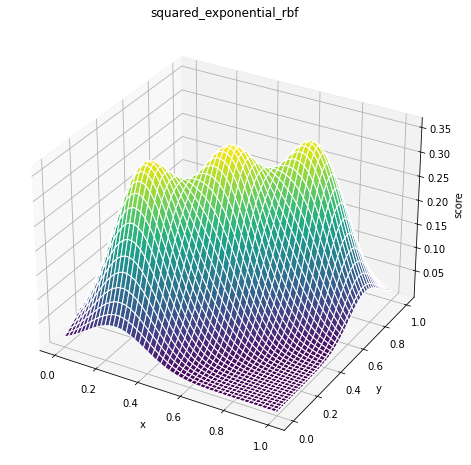

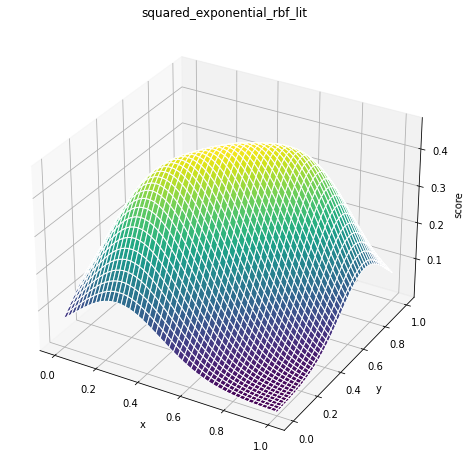

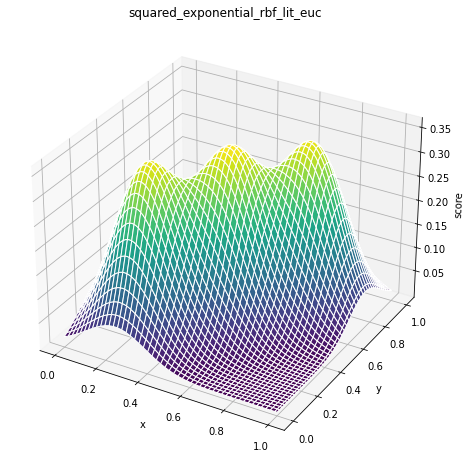

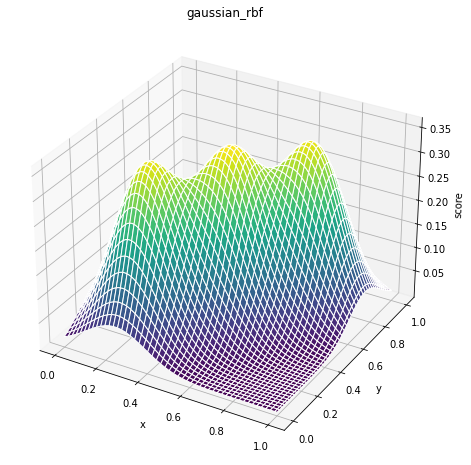

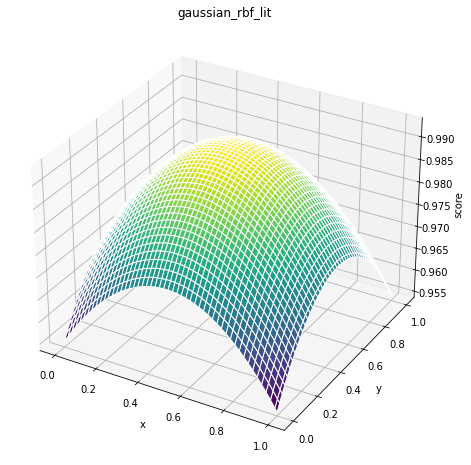

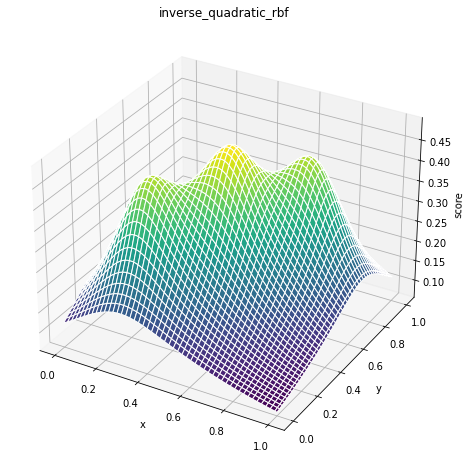

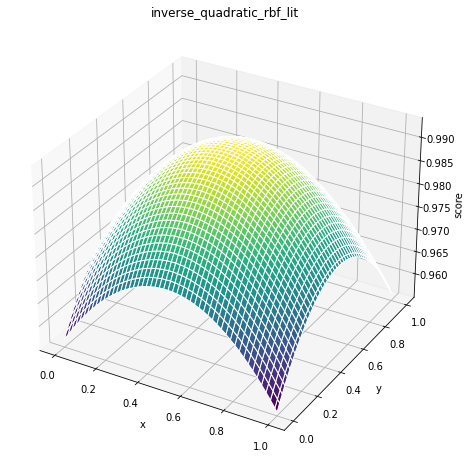

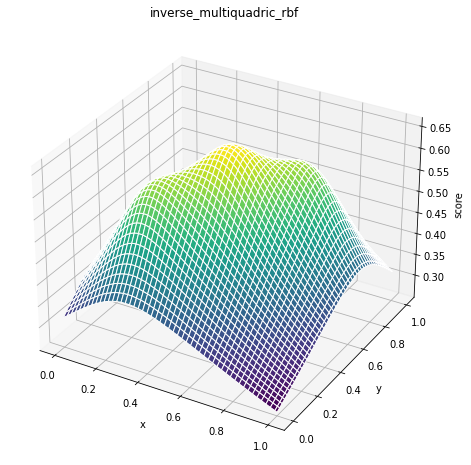

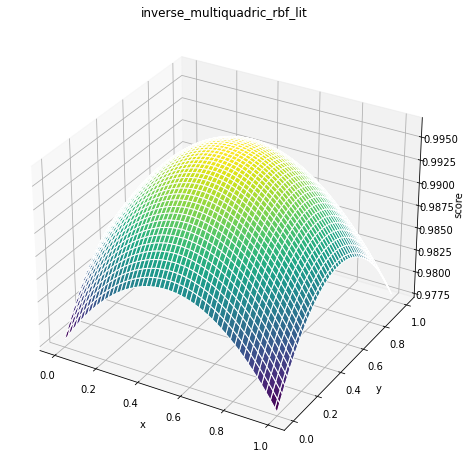

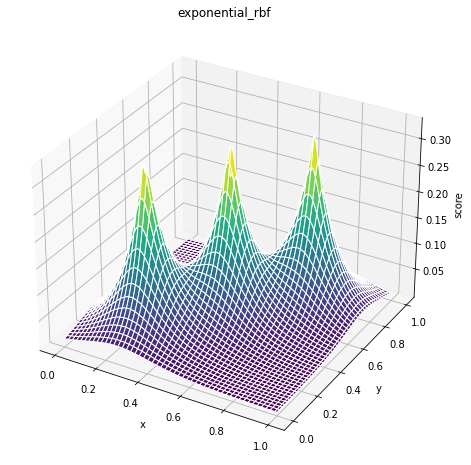

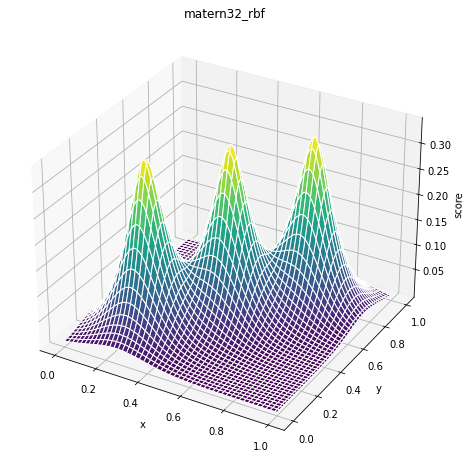

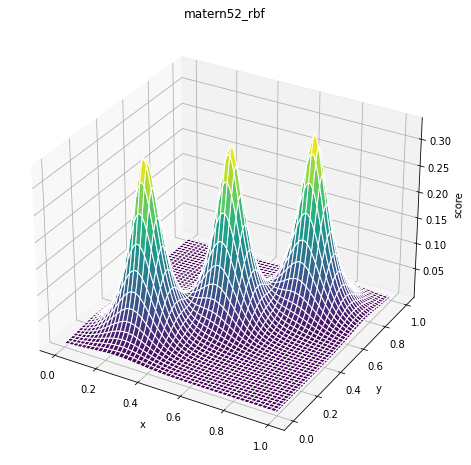

In [83]:
# visualize results
plt.rcParams['figure.figsize'] = [12, 8]
for k, score in scores.items():
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.plot_surface(X, Y, score, cmap='viridis',
                   edgecolor='white')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('score');
    ax.set_title(k)
    
    plt.show()

In [6]:
Theta = np.array([-0.589524547783965, 0.48682086719207174, 0.8824814917757433, 0.2651838053863035, 0.27877586333223814, 0.889154065602996, 0.656381523687032, 0.05674319938258976, -0.013955775419352001, 0.6115821445033877, -0.1362439855782438, 0.6216487273153675, 0.4987019714790798, 0.4183267997505976, 0.9767718952298922, 0.533130692595658, -0.26275158159727297, 0.7092726153594651, 0.09046642636516355, 0.569617471273791, 0.7912599758176031, 0.9048006708469966, 0.611387827092729, 0.12278436114206126, -0.2893048246251353, 0.5853361419230902, -0.06202634665205298, 0.8444312844467061, 0.6517878452139317, 0.7404472140344134, 0.2203309959555919, 0.8621904320357701])
print(f"# decision vars: {len(Theta)}")
numberOfInputs = 2
numberOfOutputs = 4
numberOfRBF = 4
inputl = np.asarray([0.53, 0.75])

# decision vars: 32


In [7]:
def set_parameters(Theta):  
    idk = 2 * numberOfInputs - 1
    count = 0
    ws = np.zeros((numberOfOutputs, 1))
    param = []
    cparam = {"c": [], "b": [], "w": []}
    for i in range(0, numberOfRBF):
        for k in range(0, numberOfOutputs):
            idk = idk + 1
            ws[k][0] = ws[k][0] + Theta[idk]
        idk = idk + 2 * numberOfInputs
    for l in range(numberOfRBF):
        for j in range(numberOfInputs):
#             center[l][j] = Theta[count]
#             radius[l][j] = Theta[count + 1]
            cparam['c'].append(Theta[count])
            cparam['b'].append(Theta[count + 1])
            count = count + 2

        for k in range(numberOfOutputs):
            if ws[k][0] < 10 ** -6:
#                 weights[l][k] = Theta[count]
                cparam['w'].append(Theta[count]) 
            else:
#                 weights[l][k] = Theta[count] / ws[k]
                cparam['w'].append(Theta[count] / ws[k])
            count = count + 1
        param.append(cparam)
        cparam = {"c": [], "b": [], "w": []}
    return param # center, radius, weights

def RBFcontrol_law(input):
    phi = []
    for j in range(numberOfRBF):
        bf = 0
        for i in range(numberOfInputs):
            numerator = input[i] - param[j]['c'][i] #centers
            denominator = param[j]['b'][i] # radius
            if denominator < 1e-6:
                denominator = 1e-6
            bf += (numerator*numerator) / (denominator*denominator)
        phi.append(np.exp(-bf))
#     print(phi)
    out = [] 
    for k in range(numberOfOutputs):
        o = 0
        for i in range(numberOfRBF):
            o = o + param[i]['w'][k]*phi[i]
        out.append(o)
    return out

param = set_parameters(Theta)
output = RBFcontrol_law(inputl)
outputl = [item for sublist in output for item in sublist]
print(f"output: {outputl}")

output: [0.056982337379412114, 0.04661259177939901, 0.04819390639645883, 0.056710963245583126]


In [8]:
def set_parameters2(Theta):
    Theta = Theta.reshape((-1, 4))
    centerradius = Theta[::2]
    weights = Theta[1::2]
    center = centerradius[:, ::2]
    radius = centerradius[:, 1::2]
    
    ws = weights.sum(axis=0)
    for i in [np.where(ws == i)[0][0] for i in ws if i>10**-6]:
        weights[:,i]= weights[:,i]/ws[i]
    return center, radius, weights

def rbf_control_law2(inputRBF):
    center, radius, weights = set_parameters2(Theta)
    phi = squaredExponential(inputRBF, center, radius)
#     phi = gaussian(inputRBF, center, radius)
#     phi = invQuadric(inputRBF, center, radius)
    out = (weights * (phi.reshape(numberOfRBF, 1))).sum(axis=0)
    return out

def squaredExponential(inputRBF, center, radius):
    return np.exp(-(np.sum((inputRBF - center) ** 2 / (radius ** 2), axis=1)))

def squaredExponential2(inputRBF, center, radius):
    return np.exp(-(np.sum((inputRBF - center) ** 2 / (2*radius ** 2), axis=1)))

def gaussian(inputRBF, center, radius):
    return np.exp(-(np.sum((radius * (inputRBF - center)) ** 2, axis=1)))

def invQuadric(inputRBF, center, radius):
    return 1 / (1 + np.sum((radius * (inputRBF - center)) ** 2, axis=1))

output2 = rbf_control_law2(inputl)
print(f"rbf output: {list(output2)}")

rbf output: [0.056982337379412114, 0.04661259177939901, 0.04819390639645883, 0.056710963245583126]


In [72]:
from scipy.spatial.distance import cdist
def squared_exponential_rbf(rbf_input, centers, radii, weights):
    # sum over inputs
    a = rbf_input[np.newaxis, :] - centers
    b = a ** 2
    c = radii ** 2
    rbf_scores = np.exp(-(np.sum(b / c, axis=1)))
    # n_rbf x n_output, n_rbf
    weighted_rbfs = weights * rbf_scores[:, np.newaxis]
    output = weighted_rbfs.sum(axis=0)
    return output

def squared_exponential_rbf_euc(rbf_input, centers, radii, weights):
    # sum over inputs
    a = cdist(rbf_input[np.newaxis, :], centers)
    b = a.T ** 2
    c = radii ** 2
    rbf_scores = np.exp(-(np.sum(b / c, axis=1)))
    # n_rbf x n_output, n_rbf
    weighted_rbfs = weights * rbf_scores[:, np.newaxis]
    output = weighted_rbfs.sum(axis=0)
    return output


def gaussian_rbf(rbf_input, centers, radii, weights):
    a = rbf_input[np.newaxis, :] - centers
    n = a / radii
    p = n ** 2
    q = np.sum(p, axis=1)
    rbf_scores = np.exp(-1 * q)

    # n_rbf x n_output, n_rbf
    weighted_rbfs = weights * rbf_scores[:, np.newaxis]
    output = weighted_rbfs.sum(axis=0)
    return output

def gaussian_rbf_euc(rbf_input, centers, radii, weights):
    a = cdist(rbf_input[np.newaxis, :], centers)
    n = a.T / radii
    p = n ** 2
    q = np.sum(p, axis=1)
    rbf_scores = np.exp(-1 * q)

    # n_rbf x n_output, n_rbf
    weighted_rbfs = weights * rbf_scores[:, np.newaxis]
    output = weighted_rbfs.sum(axis=0)
    return output

In [17]:
def calc_types(numberOfInputs, numberOfOutputs, numberOfRBF, Theta, rbf_function):
    types = []
    c_i = []
    r_i = []
    w_i = []
    count = itertools.count()
    for i in range(numberOfRBF):
        for j in range(numberOfInputs):
            types.append(Real(-1, 1))  # center
            c_i.append(next(count))
            types.append(Real(0, 1))  # radius
            r_i.append(next(count))

    for _ in range(numberOfRBF):
        for _ in range(numberOfOutputs):
            types.append(Real(0, 1))  # weight
            w_i.append(next(count))  # weight
    c_i = np.asarray(c_i, dtype=np.int16)
    r_i = np.asarray(r_i, dtype=np.int16)
    w_i = np.asarray(w_i, dtype=np.int16)
    return c_i, r_i, w_i

def calc_param(numberOfInputs, numberOfOutputs, numberOfRBF, Theta, rbf):
#     c_i, r_i, w_i = calc_types(numberOfInputs, numberOfOutputs, numberOfRBF, Theta, rbf)
    c_i = np.asarray([0,2,8,10,16,18,24,26], dtype=np.int16)
    r_i = np.asarray([1,3,9,11,17,19,25,27], dtype=np.int16)
    w_i = np.asarray([4,5,6,7,12,13,14,15,20,21,22,23,28,29,30,31], dtype=np.int16)
    decision_vars = Theta.copy()

    centers = decision_vars[c_i].reshape((numberOfRBF, numberOfInputs))
    radii = decision_vars[r_i].reshape((numberOfRBF, numberOfInputs))
    weights = decision_vars[w_i].reshape((numberOfRBF, numberOfOutputs))

    # sum of weights per input is 1
    weights /= weights.sum(axis=0)[np.newaxis, :]
    return centers, radii, weights

[0.05698234 0.04661259 0.04819391 0.05671096]


In [73]:
entry = rbf_functions.squared_exponential_rbf
rbf = rbf_functions.RBF(numberOfRBF, numberOfInputs, numberOfOutputs, rbf_function=entry)
inp_c, inp_r, inp_w = calc_param(numberOfInputs, numberOfOutputs, numberOfRBF, Theta, rbf)
print(squared_exponential_rbf(inputl, inp_c, inp_r, inp_w))
print(squared_exponential_rbf_euc(inputl, inp_c, inp_r, inp_w))

[0.05698234 0.04661259 0.04819391 0.05671096]
[0.00331737 0.00267342 0.00275498 0.00324307]


In [74]:
entry = rbf_functions.gaussian_rbf
rbf = rbf_functions.RBF(numberOfRBF, numberOfInputs, numberOfOutputs, rbf_function=entry)
inp_c, inp_r, inp_w = calc_param(numberOfInputs, numberOfOutputs, numberOfRBF, Theta, rbf)
print(gaussian_rbf(inputl, inp_c, inp_r, inp_w))
print(gaussian_rbf_euc(inputl, inp_c, inp_r, inp_w))

[0.05698234 0.04661259 0.04819391 0.05671096]
[0.00331737 0.00267342 0.00275498 0.00324307]
